<a href="https://colab.research.google.com/github/RafaelSdeSouza/astrostats-2025/blob/main/AutoEncoder_my_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to Train an Autoencoder with Your Own Dataset

This guide provides a  template for training an autoencoder using a custom dataset.  Use this guide as a foundational template for your projects.

## **Step 1: Dataset Selection**
- **Action:** Start by choosing a dataset for your project. Platforms like Kaggle offer a wide variety of datasets suitable for various tasks.

## **Step 2: Model Architecture**
- **Action:** Design the architecture of your autoencoder. An autoencoder typically consists of two main components: an encoder that compresses the input data into a lower-dimensional latent representation, and a decoder that reconstructs the input data from the latent representation.

## **Exercise for Further Learning:**

1. **Latent Space Visualization:** Research and implement methods to plot the latent representation of your dataset. For guidance, refer to the additional Colab notebook I've shared.


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation, Conv2D, Conv2DTranspose
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import imageio
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_directory = "/content/drive/MyDrive/PAM_MachineLearning/Balls/"  # Replace with the directory name containing your dataset
train_directory = os.path.join(data_directory, "train")
test_directory = os.path.join(data_directory, "test")
image_size = (128, 128)  # Adjust this tuple according to your requirements

In [ ]:
# Function to load and preprocess data
def load_and_preprocess_data(directory, image_size):
    data = []
    labels = []
    for category in os.listdir(directory):
        category_folder = os.path.join(directory, category)
        label = category  # Use the folder name as the label

        for image_name in os.listdir(category_folder):
            image_path = os.path.join(category_folder, image_name)
            # Load and preprocess the image
            image = tf.keras.preprocessing.image.load_img(image_path, target_size=image_size)
            image_array = tf.keras.preprocessing.image.img_to_array(image)
            image_array = image_array / 255.0  # Normalize
            data.append(image_array)
            labels.append(label)
    return np.array(data), np.array(labels)
# Load Train and Test data
X_train, train_labels = load_and_preprocess_data(train_directory, image_size)
X_valid, test_labels = load_and_preprocess_data(test_directory, image_size)


In [ ]:
from collections import Counter
label_counter_train = Counter(train_labels)
label_counter_train

Counter({'american_football': 384,
         'baseball': 400,
         'basketball': 340,
         'billiard_ball': 646,
         'bowling_ball': 440,
         'cricket_ball': 581,
         'football': 604,
         'golf_ball': 549,
         'hockey_ball': 530,
         'hockey_puck': 390,
         'rugby_ball': 493,
         'shuttlecock': 429,
         'table_tennis_ball': 620,
         'tennis_ball': 490,
         'volleyball': 432})

In [ ]:
X_train.shape

(7328, 128, 128, 3)

## Stacked Autoencoder

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

stacked_encoder = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(50, activation="relu")
])
stacked_decoder = tf.keras.Sequential([
     tf.keras.layers.Dense(50, activation="relu"),
    tf.keras.layers.Dense(100, activation="relu"),
     tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(128 * 128*3),
    tf.keras.layers.Reshape([128, 128,3])
])
stacked_ae = tf.keras.Sequential([stacked_encoder, stacked_decoder])



stacked_ae.compile(loss="mse", optimizer="nadam")
history = stacked_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid))

Epoch 1/10
229/229 [==============================] - 54s 223ms/step - loss: 0.0698 - val_loss: 0.0524
Epoch 2/10
229/229 [==============================] - 51s 224ms/step - loss: 0.0498 - val_loss: 0.0471
Epoch 3/10
229/229 [==============================] - 51s 221ms/step - loss: 0.0468 - val_loss: 0.0440
Epoch 4/10
229/229 [==============================] - 51s 222ms/step - loss: 0.0431 - val_loss: 0.0427
Epoch 5/10
229/229 [==============================] - 48s 210ms/step - loss: 0.0421 - val_loss: 0.0409
Epoch 6/10
229/229 [==============================] - 49s 213ms/step - loss: 0.0412 - val_loss: 0.0467
Epoch 7/10
229/229 [==============================] - 49s 216ms/step - loss: 0.0402 - val_loss: 0.0407
Epoch 8/10
229/229 [==============================] - 51s 224ms/step - loss: 0.0388 - val_loss: 0.0398
Epoch 9/10
229/229 [==============================] - 49s 212ms/step - loss: 0.0389 - val_loss: 0.0372
Epoch 10/10
229/229 [==============================] - 48s 208ms/step - l

In [ ]:
def plot_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = np.clip(model.predict(images[:n_images]), 0, 1)
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plt.imshow(images[image_index], cmap="binary")
        plt.axis("off")
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plt.imshow(reconstructions[image_index], cmap="binary")
        plt.axis("off")



1/1 [==============================] - 0s 210ms/step


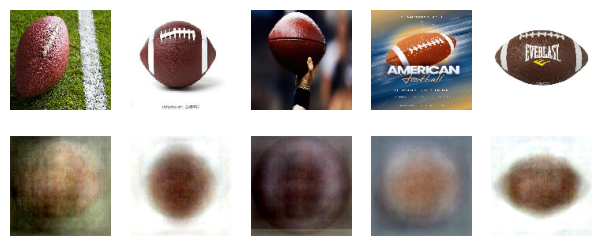

In [ ]:
plot_reconstructions(stacked_ae)
plt.show()

# Convolutional Autoencoder (much better, but slow).

In [ ]:
conv_encoder = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(128, 128, 3)),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), padding='same'),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2), padding='same')
])
conv_decoder = tf.keras.Sequential([
    tf.keras.layers.Conv2DTranspose(128, (3, 3), strides=2, activation='relu', padding='same'),
    tf.keras.layers.Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same'),
    tf.keras.layers.Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same'),
    tf.keras.layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')
])
conv_ae = tf.keras.Sequential([conv_encoder, conv_decoder])

conv_ae.compile(loss="mse", optimizer="nadam")
history = conv_ae.fit(X_train, X_train, epochs=6,
                         validation_data=(X_valid, X_valid))

1/1 [==============================] - 0s 253ms/step


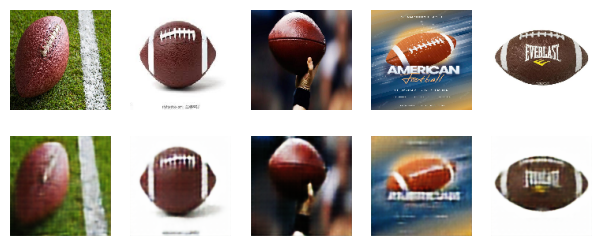

In [ ]:
# extra code – shows the reconstructions
plot_reconstructions(conv_ae)
plt.show()

In [ ]:
import matplotlib as mpl

from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE(init="pca", learning_rate="auto", random_state=42)
X_valid_2D = tsne.fit_transform(X_valid_compressed)
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=test_labels, s=10, cmap="tab10")
plt.show()


plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
Z = X_valid_2D
Z = (Z - Z.min()) / (Z.max() - Z.min())  # normalize to the 0-1 range
plt.scatter(Z[:, 0], Z[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(Z):
    dist = ((position - image_positions) ** 2).sum(axis=1)
    if dist.min() > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)

plt.axis("off")
plt.show()